# Get data from https://drive.google.com/drive/folders/1Xnpsh8IvfZyIxO8vI4vTt0O2Kw1STWZC?usp=sharing

# Installs

In [ ]:
!pip install mne

# Data import, load raw, filtering, etc

## Imports

In [ ]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import mne
import copy
from scipy.fftpack import fft

import torch
import torch.nn as nn
import torchvision.transforms

from sklearn.preprocessing import RobustScaler
from collections import OrderedDict
from pylab import rcParams

import torch
import torch.nn as nn
import torch.nn.functional as functional
import torch.optim as optim


from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

## Load raw data

In [ ]:
data = scipy.io.loadmat('/content/EEGdata.mat')
eegdata=data['EEGdata']

eegdata = eegdata.transpose()

chl_names = ["FC3", "FCz", "FC4", "C5", "C3", "C1", "Cz", "C2", "C4", "C6", "CP3", "CPz", "CP4"]
sfreq = 512
n_channels = 13

# Initialize an info structure
info = mne.create_info(
        ch_names = chl_names,
        ch_types = ['eeg']*n_channels,
        sfreq    = sfreq
        )

info.set_montage('standard_1020')
print('Event created :', info)
raw = mne.io.RawArray(eegdata, info)

Event created : <Info | 8 non-empty values
 bads: []
 ch_names: FC3, FCz, FC4, C5, C3, C1, Cz, C2, C4, C6, CP3, CPz, CP4
 chs: 13 EEG
 custom_ref_applied: False
 dig: 16 items (3 Cardinal, 13 EEG)
 highpass: 0.0 Hz
 lowpass: 256.0 Hz
 meas_date: unspecified
 nchan: 13
 projs: []
 sfreq: 512.0 Hz
>
Creating RawArray with float64 data, n_channels=13, n_times=551673
    Range : 0 ... 551672 =      0.000 ...  1077.484 secs
Ready.


## Filtering:

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.2 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.20
- Lower transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.10 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 8449 samples (16.502 s)

Effective window size : 1.000 (s)
Effective window size : 1.000 (s)


<Figure size 1600x800 with 0 Axes>

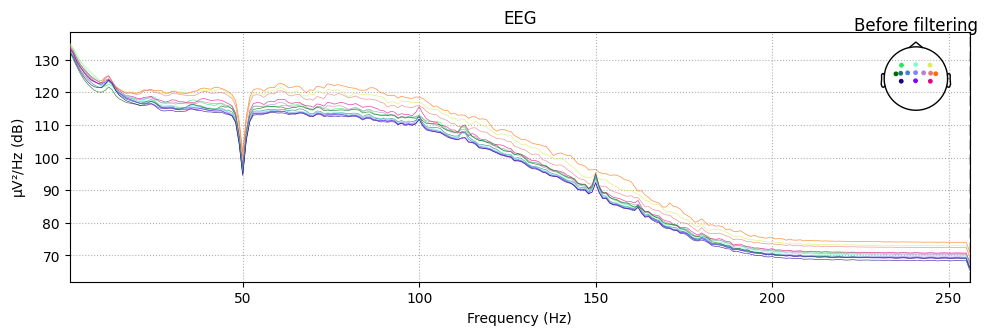

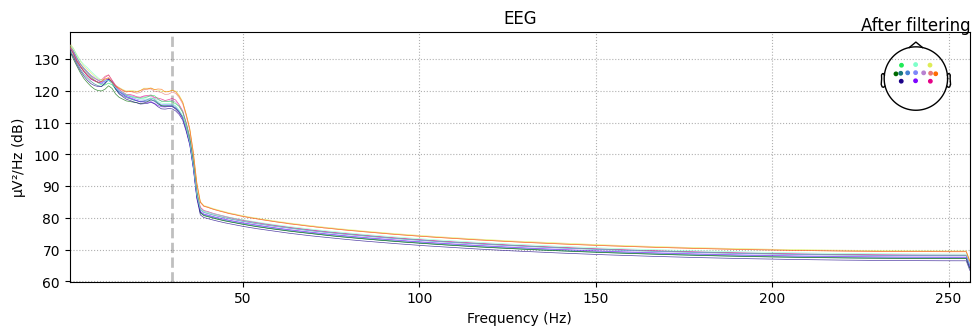

In [ ]:
eeg_raw = copy.deepcopy(raw)
eeg_raw_filtered = copy.deepcopy(eeg_raw)
eeg_raw_filtered.filter(0.2, 30, method='fir', phase='zero')
eeg_data_filtered = eeg_raw_filtered.get_data()

fmin = 1
fmax = 256
n_fft = 512
plt.figure(figsize=(16, 8))
psds1 = eeg_raw.compute_psd(method="welch", picks='eeg',fmin=fmin, fmax=fmax, n_fft=n_fft, n_overlap = n_fft // 2 )
psds1.plot()
plt.title('Before filtering')
psds2 = eeg_raw_filtered.compute_psd(method="welch", picks='eeg',fmin=fmin, fmax=fmax, n_fft=n_fft, n_overlap =  n_fft // 2 )
psds2.plot()
plt.title('After filtering')
plt.show()
raw = copy.deepcopy(eeg_raw_filtered)

## Epochs:


creating trials start points

In [ ]:
trial_mat = scipy.io.loadmat('/content/trial.mat')

trial_data=trial_mat['trial']
trial_data.shape

trial_tr = trial_data.transpose()

tr = trial_tr[0]
trial_start_points = tr
tmin = -0.5
tmax = 2 # define epochs around events (in s)

event_id = dict(one = 1, two = 2, three = 3, four = 4)

events = np.array([[start_point, 0, i+1] for i, start_point in enumerate(trial_start_points)])
epochs = mne.Epochs(raw, events, tmin=tmin, tmax=tmax, baseline=None)

Not setting metadata
100 matching events found
No baseline correction applied
0 projection items activated


# Modeling

### dataset for all channels

In [ ]:
cut_train_test = 80
number_of_classes = 1
learning_rate = 1e-5

epochs_data = epochs.get_data()

eeg_tensor = np.squeeze(epochs_data)
eeg_tensor = torch.tensor(eeg_tensor).float()
eeg_tensor = eeg_tensor.to(torch.float32)

eeg_tensor = eeg_tensor.permute(0, 2, 1)

eeg_data_shape = eeg_tensor.shape
eeg_sample_count = 100
eeg_sample_length = 1281
num_of_channels = 13

Using data from preloaded Raw for 100 events and 1281 original time points ...
torch.Size([100, 1281, 13])
100
13
1281


### create trainig&testing dataset

In [ ]:
training_epochs = eeg_tensor[0:cut_train_test]
test_epochs = eeg_tensor[cut_train_test:eeg_sample_count]

## create trainig&testing labels

In [ ]:
label_mat = scipy.io.loadmat('/content/label.mat')
labels=label_mat['label']

labels = labels.transpose()
for i in range(len(labels)):
  labels[i]-=1
labels = labels.transpose()
labels = torch.tensor(labels).float()
labels = labels.to(torch.float32)

train_labels = np.squeeze(labels[0:cut_train_test])
test_labels = np.squeeze(labels[cut_train_test:eeg_sample_count])

## LDA

In [ ]:
#reshape for LDA
X = epochs.get_data().reshape(100, -1)
X_train, X_test, y_train, y_test = train_test_split(X, labels.ravel(), test_size=0.2, random_state=42)

# Initialize and fit the LDA classifier
lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)

# Predict labels on the test set
y_pred = lda.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.2f}")

Using data from preloaded Raw for 100 events and 1281 original time points ...
Test Accuracy: 0.60


## define net class

In [ ]:
class Net(nn.Module):
    def __init__(self, _input_size, num_classes):
        super().__init__()
        self.conv1d1 = nn.Sequential(
            nn.Conv1d(in_channels=_input_size, out_channels=300, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2)
        )
        self.lstm = nn.LSTM(input_size=300, hidden_size=64, num_layers=1, batch_first=True)
        self.fc = nn.Linear(64, num_classes)

    def forward(self, x):
        x = self.conv1d1(x)
        x = x.permute(0, 2, 1)  # Reshape for LSTM
        out, _ = self.lstm(x)
        out = out[:, -1, :]  # Take the final LSTM output
        out = self.fc(out)
        out = np.squeeze(out)
        out = functional.sigmoid(out)
        return out


net = Net(eeg_sample_length, number_of_classes)

In [ ]:
criterion = nn.BCELoss()
optimizer = optim.Adam(net.parameters(), lr = learning_rate)

### accuracy func

In [ ]:
def calc_acc(input, target):
  count = 0
  for i in range(len(input)):
    inpt = torch.round(input[i])
    tgt = torch.round(target[i])
    if inpt == tgt:
      count += 1
  return float(count/len(input))

## Model training

In [ ]:
loss_data = []
val_loss_data = []
acc_data_train = []
acc_data_val = []
interation_n = 50
for i in range(interation_n):
  net.train()
  optimizer.zero_grad()

  outputs = net(training_epochs)

  loss = criterion(outputs, train_labels)
  loss.backward()
  optimizer.step()

  loss_data.append(loss.detach().numpy())
  acc_data_train.append(calc_acc(outputs, train_labels))

  with torch.no_grad():
      net.eval()
      test_outputs = net(test_epochs)
      test_loss = criterion(test_outputs, test_labels)

      val_loss_data.append(test_loss.detach().numpy())
      acc_data_val.append(calc_acc(test_outputs, test_labels))


print('Finished Training')

Finished Training


## Plot

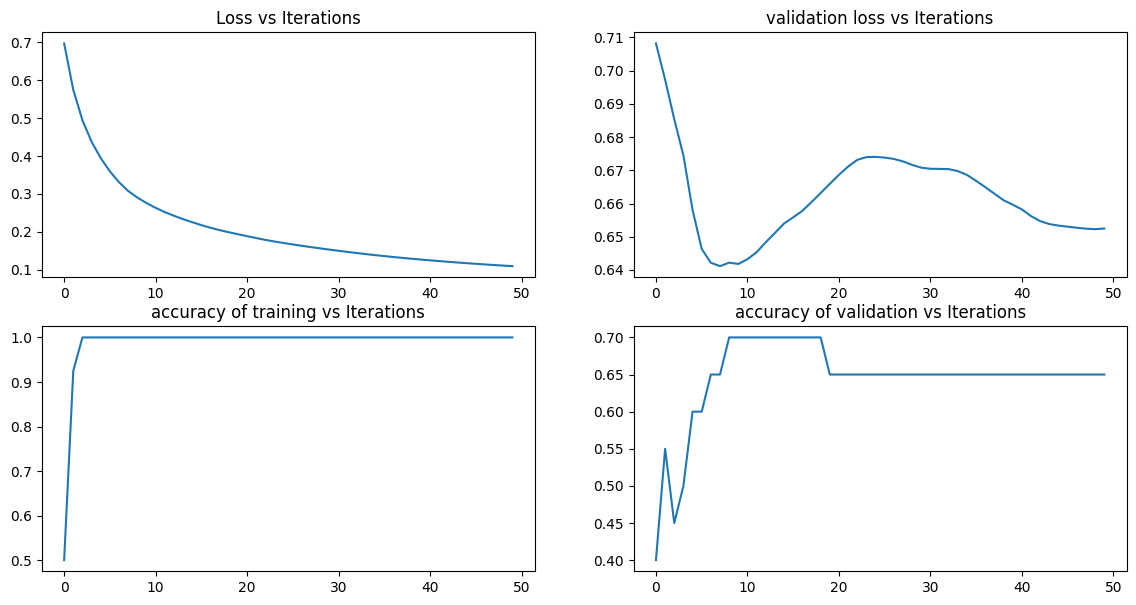

In [ ]:
plt.figure(figsize=(14, 7))
plt.subplot(2, 2, 1)
plt.plot(list(range(0, len(loss_data))), loss_data)
plt.title("Loss vs Iterations")

plt.subplot(2, 2, 2)
plt.plot(list(range(0, len(val_loss_data))), val_loss_data)
plt.title("validation loss vs Iterations")

plt.subplot(2, 2, 3)
plt.plot(list(range(0, len(acc_data_train))), acc_data_train)
plt.title("accuracy of training vs Iterations")

plt.subplot(2, 2, 4)
plt.plot(list(range(0, len(acc_data_val))), acc_data_val)
plt.title("accuracy of validation vs Iterations")

plt.show()

# Save trained model

In [ ]:
#torch.save(net, "/content/another_net_trained_rather_well")

# Test pre-trained

In [ ]:
def test_model(cnn_model):
  with torch.no_grad():
      cnn_model.eval()
      test_outputs = cnn_model(test_epochs)
      test_loss = criterion(test_outputs, test_labels)
      print("BCELoss: {:f}; Accuracy: {:f}".format(test_loss.detach().numpy(),calc_acc(test_outputs, test_labels) ))

In [ ]:
pre_trained = torch.load("/content/net_trained_well")
test_model(pre_trained)


BCELoss: 0.671269; Accuracy: 0.600000


In [ ]:
pre_trained2 = torch.load("/content/net_trained_rather_well")
test_model(pre_trained2)


BCELoss: 0.623617; Accuracy: 0.700000


In [ ]:
pre_trained3 = torch.load("/content/another_net_trained_rather_well")
test_model(pre_trained3)


BCELoss: 0.622200; Accuracy: 0.750000


# Visualization

In [ ]:
raw.plot(scalings=50, duration = 1000, show_scrollbars=False, show_scalebars=False)

In [ ]:
epochs.plot(scalings=45, n_epochs= 3, n_channels= 7)
plt.show()

In [ ]:
sensor_position_figure = epochs.plot_sensors(show_names=True)